In the context of credit card transactions, "fraud" refers to unauthorized or deceptive activities resulting in financial losses. Common types of credit card fraud include:
Transaction-related fraud
Unauthorized transactions: Charges made without cardholder's consent.
Card-not-present (CNP) fraud: Online or phone transactions using stolen card details.
Card skimming: Capturing card data using compromised ATMs or point-of-sale devices.
Cardholder-related fraud
Identity theft: Using stolen personal information to obtain credit cards.

Card application fraud: Submitting fake applications for credit cards.
Merchant-related fraud
Friendly fraud: Merchants processing unauthorized transactions or falsifying refunds.
Merchant identity theft: Impersonating legitimate merchants.
Other types of fraud
Phishing: Scams targeting cardholders' sensitive information.
Card trapping: Withholding cards in ATMs or payment terminals.
Counterfeit cards: Creating fake cards using stolen data.

In [1]:
# Here are the attribute names for the credit card fraud detection dataset:
# Transaction Attributes
# TransactionAmount
# TransactionTime
# MerchantCategory
# CardType
# IsFraudulent
# Derived/Engineered Attributes
# TransactionVelocity (transactions per hour)
# AmountVariance (standard deviation of transaction amounts)
# MerchantCategoryFrequency (transactions per merchant)
# CardTypeFrequency (transactions per card type)
# TimeOfDay (hourly transaction distribution)
# Additional Attributes (optional)
# UserID (unique customer identifier)
# CardID (unique card identifier)
# MerchantID (unique merchant identifier)
# Location (transaction location)
# DeviceInfo (device used for transaction)
# Real-World Dataset Attributes
# Kaggle's "Credit Card Fraud Detection" dataset:
# Time
# V1-V28 (anonymized transaction attributes)
# Class (fraudulent/legitimate)
# Amount

This tutorial demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another. You will work with the Credit Card Fraud Detection dataset hosted on Kaggle. The aim is to detect a mere 492 fraudulent transactions from 284,807 transactions in total. You will use Keras to define the model and class weights to help the model learn from the imbalanced data. .

In [2]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Data processing and exploration
Download the Kaggle Credit Card Fraud data set
Pandas is a Python library with many helpful utilities for loading and working with structured data. It can be used to download CSVs into a Pandas DataFrame.

In [4]:
file = tf.keras.utils

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [5]:

raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Examine the class label imbalance
Let's look at the dataset imbalance:

In [7]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



In [8]:
neg # not fraud 

np.int64(284315)

In [9]:
pos # fraud

np.int64(492)

Clean, split and normalize the data
The raw data has a few issues. First the Time and Amount columns are too variable to use directly. Drop the Time column (since it's not clear what it means) and take the log of the Amount column to reduce its range.

In [10]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount')+eps)

In [11]:
cleaned_df.head(1)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105


In [12]:
cleaned_df.columns

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Class', 'Log Amount'],
      dtype='object')

In [13]:
cleaned_df.isna().sum()

V1            0
V2            0
V3            0
V4            0
V5            0
V6            0
V7            0
V8            0
V9            0
V10           0
V11           0
V12           0
V13           0
V14           0
V15           0
V16           0
V17           0
V18           0
V19           0
V20           0
V21           0
V22           0
V23           0
V24           0
V25           0
V26           0
V27           0
V28           0
Class         0
Log Amount    0
dtype: int64

In [14]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   V1          284807 non-null  float64
 1   V2          284807 non-null  float64
 2   V3          284807 non-null  float64
 3   V4          284807 non-null  float64
 4   V5          284807 non-null  float64
 5   V6          284807 non-null  float64
 6   V7          284807 non-null  float64
 7   V8          284807 non-null  float64
 8   V9          284807 non-null  float64
 9   V10         284807 non-null  float64
 10  V11         284807 non-null  float64
 11  V12         284807 non-null  float64
 12  V13         284807 non-null  float64
 13  V14         284807 non-null  float64
 14  V15         284807 non-null  float64
 15  V16         284807 non-null  float64
 16  V17         284807 non-null  float64
 17  V18         284807 non-null  float64
 18  V19         284807 non-null  float64
 19  V2

Pop 'Amount' column: cleaned_df.pop('Amount') removes the 'Amount' column from the DataFrame cleaned_df and returns its values.
Add epsilon (eps): + eps adds a small value (eps) to the 'Amount' values to prevent logarithmic errors when encountering zero values.
Natural logarithm: np.log() calculates the natural logarithm of the resulting values.

Split the dataset into train, validation, and test sets. The validation set is used during the model fitting to evaluate the loss and any metrics, however the model is not fit with this data. The test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data. This is especially important with imbalanced datasets where overfitting is a significant concern from the lack of training data.

In [15]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class')).reshape(-1, 1)  # like expand_dims() in tensor
bool_train_labels = train_labels[:, 0] != 0
val_labels = np.array(val_df.pop('Class')).reshape(-1, 1)
test_labels = np.array(test_df.pop('Class')).reshape(-1, 1)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

Pop 'Class' column: train_df.pop('Class') removes the 'Class' column from the DataFrame train_df and returns its values.
Convert to NumPy array: np.array() converts the popped column values to a NumPy array.
Reshape array: .reshape(-1, 1) transforms the array into a 2D shape, where each row represents a sample and the single column represents the label.
Boolean conversion: bool_train_labels = train_labels[:, 0] != 0 creates a boolean mask where:
True indicates a positive class label (non-zero).
False indicates a negative class label (zero).

In [16]:
train_labels[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [17]:
bool_train_labels[:10]

array([False, False, False, False, False, False, False, False, False,
       False])

In [18]:
train_features[:2]

array([[-1.36785723e+00, -8.13420827e-01, -1.46699877e+00,
         1.95915786e+00, -2.63258535e+00,  2.52811204e+00,
         1.44113788e+00, -4.11929113e+00, -8.56090572e-01,
        -7.23679271e-01,  1.17738963e+00,  1.52732020e+00,
         5.61248248e-01,  9.25852300e-01,  5.68442039e-03,
        -2.05302424e-01,  1.85336841e-01, -2.46522172e-01,
         3.31744816e-01,  5.52016131e-01, -4.44441704e-01,
         8.69447963e-02, -3.05796987e+00, -3.19732158e-02,
        -3.04744763e-01, -2.21323330e-01,  9.20859538e-01,
         1.24878124e-01,  7.13089963e+00],
       [-3.15911302e-01, -4.36307989e-01,  1.54762461e+00,
        -1.34800639e+00, -5.93091140e-01,  1.75357466e+00,
        -9.13081045e-01,  6.03919162e-01, -2.72902702e+00,
         1.51107054e+00,  1.97253854e+00, -9.10627861e-01,
        -8.50826533e-01,  2.36431000e-01,  1.84312321e+00,
        -2.16568202e+00,  2.16479765e+00, -9.66569827e-01,
         3.28212149e-01, -2.87023343e-01,  4.14130526e-02,
         5.84

In [19]:
np.mean(train_features[:1])

np.float64(0.1022890285338076)

We check whether the distribution of the classes in the three sets is about the same or not

In [20]:
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.0017
Average class probability in validation set: 0.0018
Average class probability in test set:       0.0017


Normalize the input features using the sklearn StandardScaler. This will set the mean to 0 and standard deviation to 1.

Note: The StandardScaler is only fit using the train_features to be sure the model is not peeking at the validation or test sets.

In [21]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

In [22]:
train_features[:1]

array([[-0.69673407, -0.49060846, -0.96940933,  1.38299646, -1.92798896,
         1.90229802,  1.18628787, -3.43597892, -0.77884009, -0.66456777,
         1.15376203,  1.52531534,  0.5603379 ,  0.96272324,  0.00656821,
        -0.23351026,  0.21661138, -0.29437259,  0.40761095,  0.72033961,
        -0.60730679,  0.11863699, -4.85180054, -0.05300682, -0.58671805,
        -0.45808163,  2.29654823,  0.39325172,  2.06290839]])

In [23]:
np.mean(train_features[:1])

np.float64(-0.03974923944715103)

-5: Minimum value (lower bound).
5: Maximum value (upper bound).
Effects
Values < -5 become -5.
Values > 5 become 5.
Values within [-5, 5] remain unchanged.

In [24]:
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

In [25]:
train_features[:1]

array([[-0.69673407, -0.49060846, -0.96940933,  1.38299646, -1.92798896,
         1.90229802,  1.18628787, -3.43597892, -0.77884009, -0.66456777,
         1.15376203,  1.52531534,  0.5603379 ,  0.96272324,  0.00656821,
        -0.23351026,  0.21661138, -0.29437259,  0.40761095,  0.72033961,
        -0.60730679,  0.11863699, -4.85180054, -0.05300682, -0.58671805,
        -0.45808163,  2.29654823,  0.39325172,  2.06290839]])

In [26]:
print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (182276, 1)
Validation labels shape: (45569, 1)
Test labels shape: (56962, 1)
Training features shape: (182276, 29)
Validation features shape: (45569, 29)
Test features shape: (56962, 29)


If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.

Look at the data distribution
Next compare the distributions of the positive and negative examples over a few features. Good questions to ask yourself at this point are:

Do these distributions make sense?
Yes. You've normalized the input and these are mostly concentrated in the +/- 2 range.
Can you see the difference between the distributions?
Yes the positive examples contain a much higher rate of extreme values.

In [27]:
pos_df = pd.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)  # true 1 class
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns) # false 0 class

In [28]:
pos_df[:5]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Log Amount
0,-0.560838,-1.011942,-0.377112,3.966893,0.559451,0.331059,1.592500,-0.850201,-0.176707,1.633082,...,-0.048772,-0.563741,-0.288693,0.546826,1.799706,-1.320128,0.157485,0.084686,-2.620404,1.729132
1,-1.092244,0.651245,-1.835484,0.977045,-2.940266,0.561854,1.255827,0.161564,-2.210279,-3.809594,...,0.871610,0.196818,-1.220859,0.991475,0.158914,-0.365236,1.104453,1.055168,-0.661332,1.844467
2,-0.685861,1.292049,-1.226155,1.494477,-0.784453,-0.823021,-1.835699,0.865206,-1.723059,-3.084011,...,0.290272,0.831354,0.278294,-0.096706,-0.308236,-0.034706,-0.587413,0.986359,0.733910,-1.451698
3,0.596219,1.515108,-3.301957,3.794984,0.729452,-0.948218,-1.018262,0.299581,-2.374361,-2.809767,...,0.297698,0.167460,-0.983320,-0.128558,-1.590607,0.649141,0.142612,1.201155,0.844318,-0.661703
4,0.118357,0.569820,-3.077674,2.174528,-1.393680,-0.784435,-0.839449,0.456957,-1.005850,-3.227067,...,1.488498,1.243404,1.435213,1.585303,1.486072,-0.869787,0.400184,0.451241,-0.091942,1.428322


Text(0.5, 0.98, 'Positive distribution')

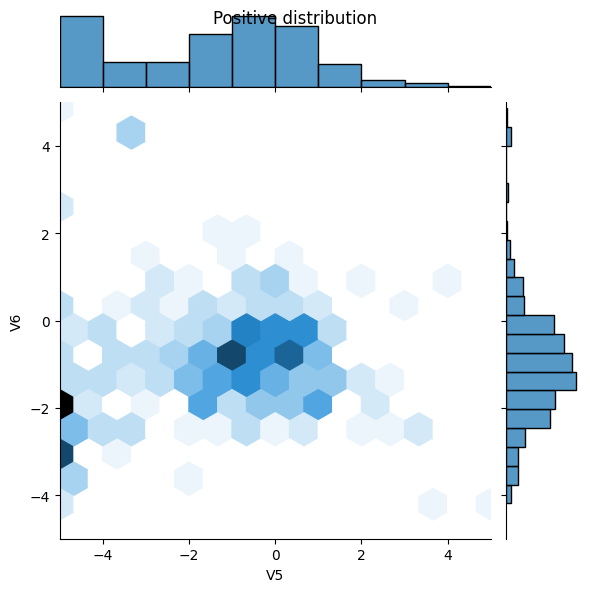

In [29]:
sns.jointplot(x=pos_df['V5'], y=pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

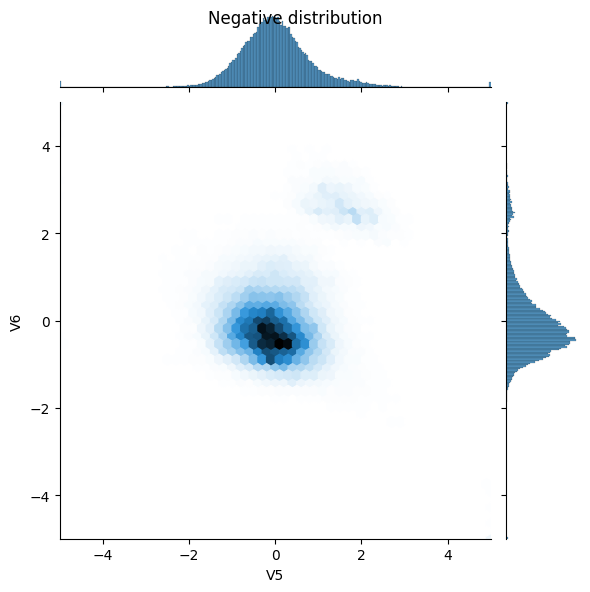

In [30]:
sns.jointplot(x=neg_df['V5'], y=neg_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

Define the model and metrics
Define a function that creates a simple neural network with a densly connected hidden layer, a dropout layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent:

In [31]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [32]:
train_features.shape

(182276, 29)

In [33]:
train_features.shape[-1]

29

In [34]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(16, activation='relu',input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

Understanding useful metrics
Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance. These can be divided into three groups.

Metrics for probability predictions
As we train our network with the cross entropy as a loss function, it is fully capable of predicting class probabilities, i.e., it is a probabilistic classifier. Good metrics to assess probabilistic predictions are, in fact, proper scoring rules. Their key property is that predicting the true probability is optimal. We give two well-known examples:

cross entropy also known as log loss
Mean squared error also known as the Brier score
Metrics for deterministic 0/1 predictions
In the end, one often wants to predict a class label, 0 or 1, no fraud or fraud. This is called a deterministic classifier. To get a label prediction from our probabilistic classifier, one needs to choose a probability threshold t
. The default is to predict label 1 (fraud) if the predicted probability is larger than t=50\%
 and all the following metrics implicitly use this default.

False negatives and false positives are samples that were incorrectly classified
True negatives and true positives are samples that were correctly classified
Accuracy is the percentage of examples correctly classified > <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mfrac>
    <mtext>true samples</mtext>
    <mtext>total samples</mtext>
  </mfrac>
</math>
Precision is the percentage of predicted positives that were correctly classified > <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mfrac>
    <mtext>true positives</mtext>
    <mtext>true positives + false positives</mtext>
  </mfrac>
</math>
Recall is the percentage of actual positives that were correctly classified > <math xmlns="http://www.w3.org/1998/Math/MathML">
  <mfrac>
    <mtext>true positives</mtext>
    <mtext>true positives + false negatives</mtext>
  </mfrac>
</math>


Note: Accuracy is not a helpful metric for this task. You can have 99.8%+ accuracy on this task by predicting False all the time.
Other metrices
The following metrics take into account all possible choices of thresholds 
.

AUC refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
AUPRC refers to Area Under the Curve of the Precision-Recall Curve. This metric computes precision-recall pairs for different probability thresholds.

Baseline model
Build the model
Now create and train your model using the function that was defined earlier. Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.

Note: Fitting this model will not handle the class imbalance efficiently. You will improve it later in this tutorial.

In [35]:
# EPOCHS = 100
# BATCH_SIZE = 2048

EPOCHS = 10
BATCH_SIZE = 64

def early_stopping():
 return tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [36]:
model = make_model()
model.summary()

d:\a27_YEARS_OLD\deep_learning\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 497 (1.94 KB)

 Trainable params: 497 (1.94 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Test run the model:


model.predict(train_features[:10])

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[0.575428  ],
       [0.13688321],
       [0.46312726],
       [0.6716962 ],
       [0.49146023],
       [0.56541616],
       [0.35775268],
       [0.44650623],
       [0.50093544],
       [0.5431354 ]], dtype=float32)

Optional: Set the correct initial bias.
These initial guesses are not great. You know the dataset is imbalanced. Set the output layer's bias to reflect that, see A Recipe for Training Neural Networks: "init well". This can help with initial convergence.

With the default bias initialization the loss should be about math.log(2) = 0.69314

In [38]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.6397


In [39]:
results
# loss=keras.losses.BinaryCrossentropy(),
# METRICS = [
#       keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
#       keras.metrics.MeanSquaredError(name='Brier score'),
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'),
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
#       keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
# ]

[0.6397312879562378,
 0.6397312879562378,
 0.2189355492591858,
 286.0,
 57831.0,
 124129.0,
 30.0,
 0.6825637817382812,
 0.004921107552945614,
 0.905063271522522,
 0.9120638370513916,
 0.06537680327892303]

The correct bias to set can be derived from:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mi>p</mi>
    <mn>0</mn>
  </msub>
  <mo>=</mo>
  <mi>p</mi>
  <mi>o</mi>
  <mi>s</mi>
  <mrow class="MJX-TeXAtom-ORD">
    <mo>/</mo>
  </mrow>
  <mo stretchy="false">(</mo>
  <mi>p</mi>
  <mi>o</mi>
  <mi>s</mi>
  <mo>+</mo>
  <mi>n</mi>
  <mi>e</mi>
  <mi>g</mi>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mn>1</mn>
  <mrow class="MJX-TeXAtom-ORD">
    <mo>/</mo>
  </mrow>
  <mo stretchy="false">(</mo>
  <mn>1</mn>
  <mo>+</mo>
  <msup>
    <mi>e</mi>
    <mrow class="MJX-TeXAtom-ORD">
      <mo>&#x2212;<!-- − --></mo>
      <msub>
        <mi>b</mi>
        <mn>0</mn>
      </msub>
    </mrow>
  </msup>
  <mo stretchy="false">)</mo>
</math>





<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mi>b</mi>
    <mn>0</mn>
  </msub>
  <mo>=</mo>
  <mo>&#x2212;<!-- − --></mo>
  <mi>l</mi>
  <mi>o</mi>
  <msub>
    <mi>g</mi>
    <mi>e</mi>
  </msub>
  <mo stretchy="false">(</mo>
  <mn>1</mn>
  <mrow class="MJX-TeXAtom-ORD">
    <mo>/</mo>
  </mrow>
  <msub>
    <mi>p</mi>
    <mn>0</mn>
  </msub>
  <mo>&#x2212;<!-- − --></mo>
  <mn>1</mn>
  <mo stretchy="false">)</mo>
</math>

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <msub>
    <mi>b</mi>
    <mn>0</mn>
  </msub>
  <mo>=</mo>
  <mi>l</mi>
  <mi>o</mi>
  <msub>
    <mi>g</mi>
    <mi>e</mi>
  </msub>
  <mo stretchy="false">(</mo>
  <mi>p</mi>
  <mi>o</mi>
  <mi>s</mi>
  <mrow class="MJX-TeXAtom-ORD">
    <mo>/</mo>
  </mrow>
  <mi>n</mi>
  <mi>e</mi>
  <mi>g</mi>
  <mo stretchy="false">)</mo>
</math>

In [40]:
# neg, pos = np.bincount(raw_df['Class'])

In [41]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

Set that as the initial bias, and the model will give much more reasonable initial guesses.

It should be near: pos/total = 0.0018

In [42]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


array([[0.00069035],
       [0.00190667],
       [0.01203131],
       [0.00312447],
       [0.01371048],
       [0.01103494],
       [0.0021172 ],
       [0.00156696],
       [0.00286137],
       [0.00313386]], dtype=float32)

With this initialization the initial loss should be approximately:
<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mo>&#x2212;<!-- − --></mo>
  <msub>
    <mi>p</mi>
    <mn>0</mn>
  </msub>
  <mi>l</mi>
  <mi>o</mi>
  <mi>g</mi>
  <mo stretchy="false">(</mo>
  <msub>
    <mi>p</mi>
    <mn>0</mn>
  </msub>
  <mo stretchy="false">)</mo>
  <mo>&#x2212;<!-- − --></mo>
  <mo stretchy="false">(</mo>
  <mn>1</mn>
  <mo>&#x2212;<!-- − --></mo>
  <msub>
    <mi>p</mi>
    <mn>0</mn>
  </msub>
  <mo stretchy="false">)</mo>
  <mi>l</mi>
  <mi>o</mi>
  <mi>g</mi>
  <mo stretchy="false">(</mo>
  <mn>1</mn>
  <mo>&#x2212;<!-- − --></mo>
  <msub>
    <mi>p</mi>
    <mn>0</mn>
  </msub>
  <mo stretchy="false">)</mo>
  <mo>=</mo>
  <mn>0.01317</mn>
</math>




In [43]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0129


This initial loss is about 50 times less than it would have been with naive initialization.

This way the model doesn't need to spend the first few epochs just learning that positive examples are unlikely. It also makes it easier to read plots of the loss during training.

Checkpoint the initial weights
To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training:

In [44]:
# initial_weights = os.path.join(tempfile.mkdtemp(), 'initial.weights.h5')
initial_weights = os.path.join(os.getcwd(), 'initial.weights.h5')
model.save_weights(initial_weights)

Confirm that the bias fix helps
Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses

In [45]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [46]:

zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(val_features, val_labels),
    verbose=0)

In [47]:
zero_bias_history

In [48]:
model = make_model()
model.load_weights(initial_weights)

In [49]:

careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=10,
    validation_data=(val_features, val_labels),
    verbose=0)

In [50]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

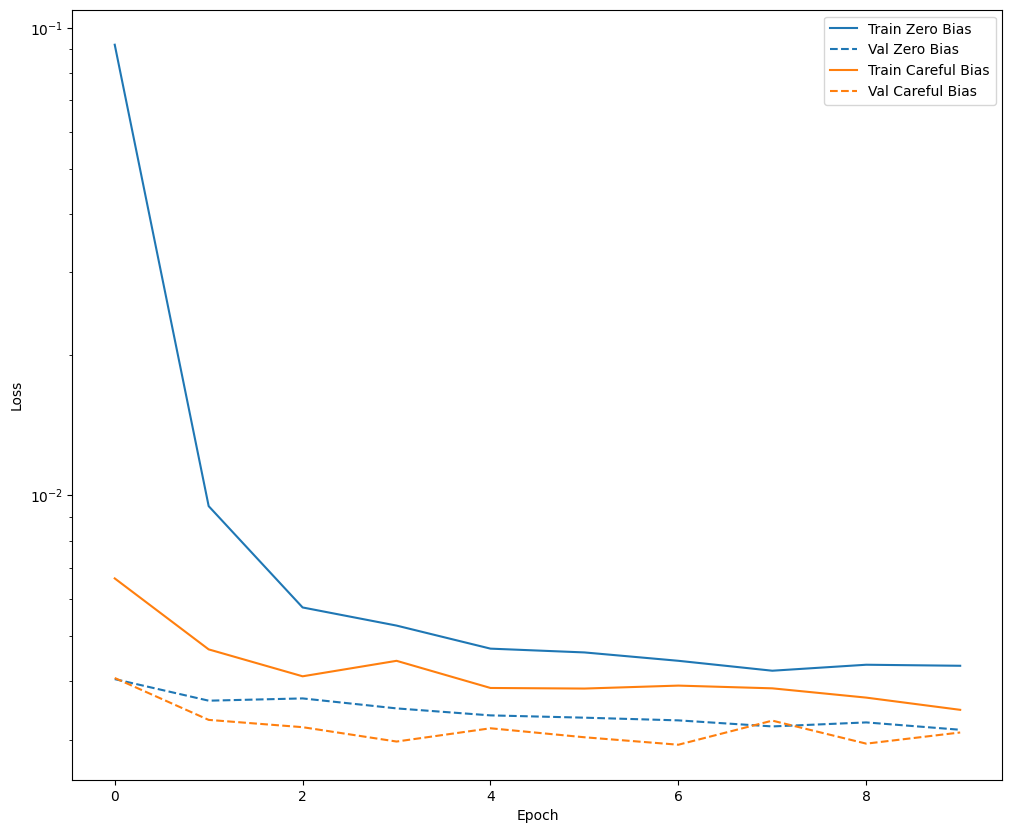

In [51]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage.

Train the model

In [52]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels))

Epoch 1/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - Brier score: 9.8399e-04 - accuracy: 0.9989 - auc: 0.8914 - cross entropy: 0.0060 - fn: 110.3277 - fp: 38.9172 - loss: 0.0087 - prc: 0.5820 - precision: 0.7574 - recall: 0.5465 - tn: 136524.0000 - tp: 127.6884 - val_Brier score: 8.0156e-04 - val_accuracy: 0.9990 - val_auc: 0.9440 - val_cross entropy: 0.0044 - val_fn: 28.0000 - val_fp: 16.0000 - val_loss: 0.0044 - val_prc: 0.6412 - val_precision: 0.7681 - val_recall: 0.6543 - val_tn: 45472.0000 - val_tp: 53.0000
Epoch 2/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - Brier score: 7.7486e-04 - accuracy: 0.9991 - auc: 0.9034 - cross entropy: 0.0049 - fn: 69.3997 - fp: 14.8298 - loss: 0.0049 - prc: 0.6740 - precision: 0.8756 - recall: 0.5763 - tn: 91055.2656 - tp: 92.4414 - val_Brier score: 6.8269e-04 - val_accuracy: 0.9993 - val_auc: 0.9502 - val_cross entropy: 0.0038 - val_fn: 17.0000 - val_fp: 17.0000 - val_loss: 0.0038 - val_prc: 0.7437 - val_precision: 0.7901 - val_recall: 0.7901

Check training history
In this section, you will produce plots of your model's accuracy and loss on the training and validation set. These are useful to check for overfitting, which you can learn more about in the Overfit and underfit tutorial.

In [53]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

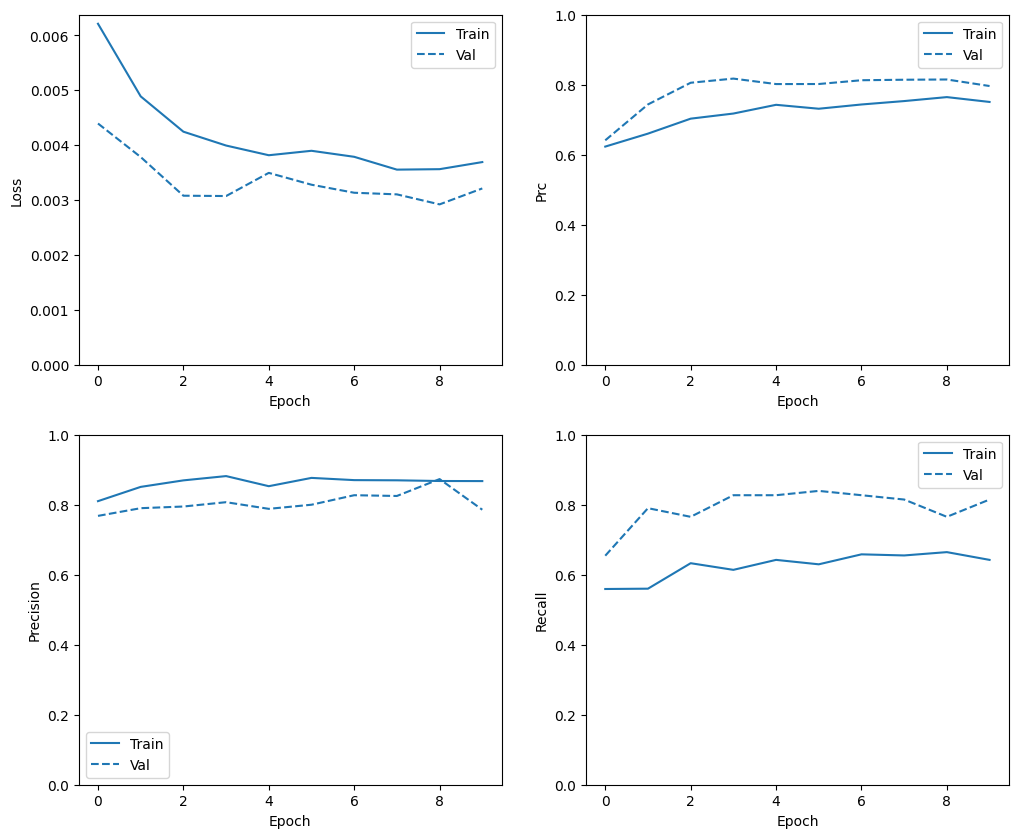

In [54]:
plot_metrics(baseline_history)

Note: That the validation curve generally performs better than the training curve. This is mainly caused by the fact that the dropout layer is not active when evaluating the model.

Evaluate metrics
You can use a confusion matrix to summarize the actual vs. predicted labels, where the X axis is the predicted label and the Y axis is the actual label:

In [55]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

2849/2849 ━━━━━━━━━━━━━━━━━━━━ 3s 997us/step
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step


In [58]:
train_predictions_baseline[:5]

array([[1.9858844e-05],
       [2.8122931e-05],
       [4.2379196e-04],
       [8.6976230e-05],
       [5.7178905e-04]], dtype=float32)

In [59]:
test_predictions_baseline[:5]

array([[1.1978485e-04],
       [3.0683786e-05],
       [4.5889261e-04],
       [9.6278061e-05],
       [1.5680036e-05]], dtype=float32)

abels: Actual true labels of the data.
predictions: Predicted probabilities or scores from your classification model.
threshold: The cutoff value above which the prediction is considered positive.

In [56]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

In [57]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()



loss :  0.002587998751550913
compile_metrics :  0.002587998751550913



Legitimate Transactions Detected (True Negatives):  56864
Legitimate Transactions Incorrectly Detected (False Positives):  3
Fraudulent Transactions Missed (False Negatives):  23
Fraudulent Transactions Detected (True Positives):  72
Total Fraudulent Transactions:  95


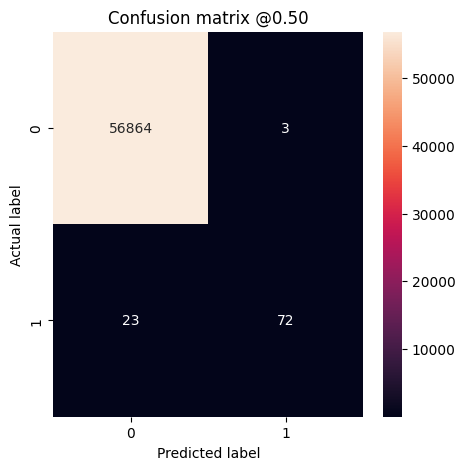

In [60]:
plot_cm(test_labels, test_predictions_baseline)

If the model had predicted everything perfectly (impossible with true randomness), this would be a diagonal matrix where values off the main diagonal, indicating incorrect predictions, would be zero. In this case, the matrix shows that you have relatively few false positives, meaning that there were relatively few legitimate transactions that were incorrectly flagged."

Changing the threshold
The default threshold of t=50\%
 corresponds to equal costs of false negatives and false positives. In the case of fraud detection, however, you would likely associate higher costs to false negatives than to false positives. This trade off may be preferable because false negatives would allow fraudulent transactions to go through, whereas false positives may cause an email to be sent to a customer to ask them to verify their card activity.

By decreasing the threshold, we attribute higher cost to false negatives, thereby increasing missed transactions at the price of more false positives. We test thresholds at 10% and at 1%.

Legitimate Transactions Detected (True Negatives):  56857
Legitimate Transactions Incorrectly Detected (False Positives):  10
Fraudulent Transactions Missed (False Negatives):  16
Fraudulent Transactions Detected (True Positives):  79
Total Fraudulent Transactions:  95
Legitimate Transactions Detected (True Negatives):  56828
Legitimate Transactions Incorrectly Detected (False Positives):  39
Fraudulent Transactions Missed (False Negatives):  15
Fraudulent Transactions Detected (True Positives):  80
Total Fraudulent Transactions:  95


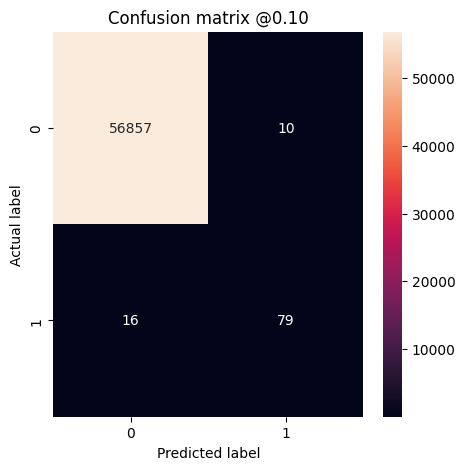

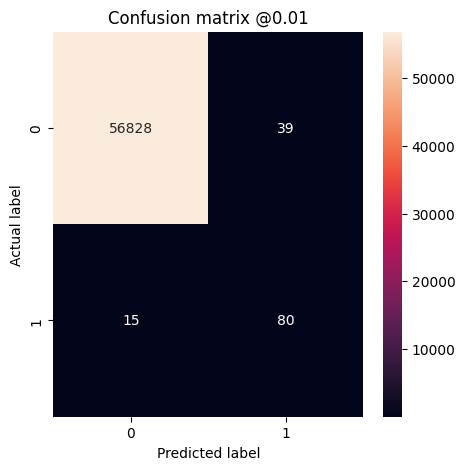

In [61]:
plot_cm(test_labels, test_predictions_baseline, threshold=0.1)
plot_cm(test_labels, test_predictions_baseline, threshold=0.01)

Plot the ROC
Now plot the ROC. This plot is useful because it shows, at a glance, the range of performance the model can reach by tuning the output threshold over its full range (0 to 1). So each point corresponds to a single value of the threshold.

In [62]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

abels: Actual true labels of the data (binary classification).
predictions: Predicted probabilities or scores from your classification model.
name: Label for the plot (e.g., model name).
kwargs: Additional keyword arguments for customization (e.g., color, linestyle).
Explanation
roc_curve(): Computes the Receiver Operating Characteristic (ROC) curve metrics.
fp (False Positive Rate): Proportion of true negatives incorrectly classified as positives.
tp (True Positive Rate): Proportion of true positives correctly classified.
_: Third return value (thresholds) is ignored

plt.plot(): Creates a ROC curve plot.
100*fp and 100*tp: Convert rates to percentages.
label=name: Assigns a label for the plot.
linewidth=2: Sets line width.
kwargs: Applies additional customization options.

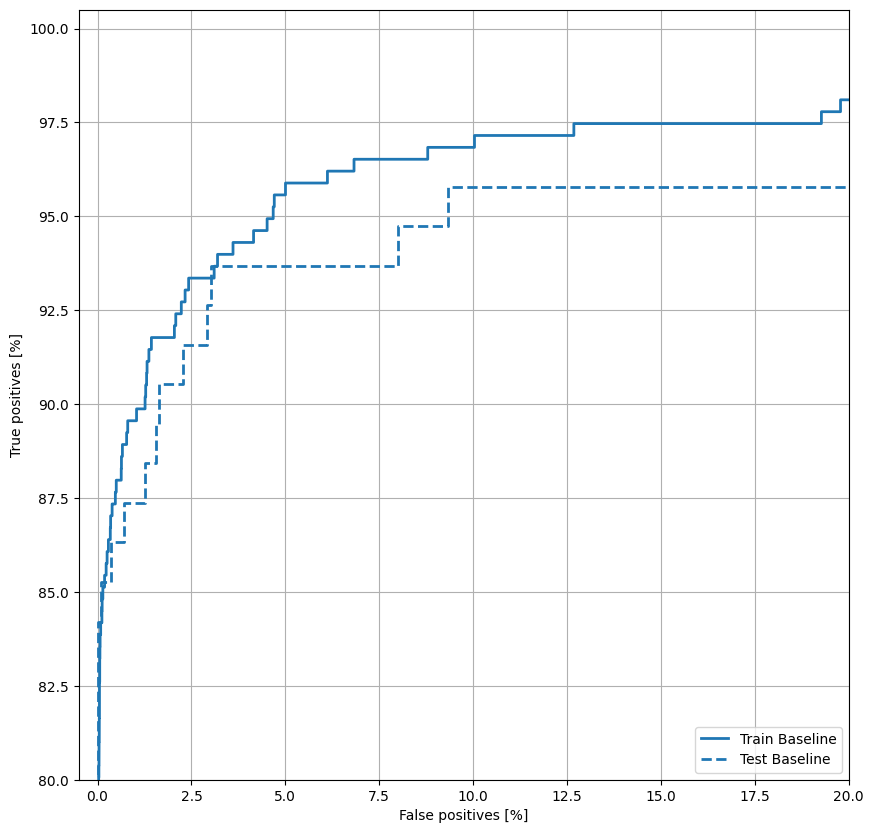

In [63]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

Plot the PRC
Now plot the AUPRC. Area under the interpolated precision-recall curve, obtained by plotting (recall, precision) points for different values of the classification threshold. Depending on how it's calculated, PR AUC may be equivalent to the average precision of the model.

In [64]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

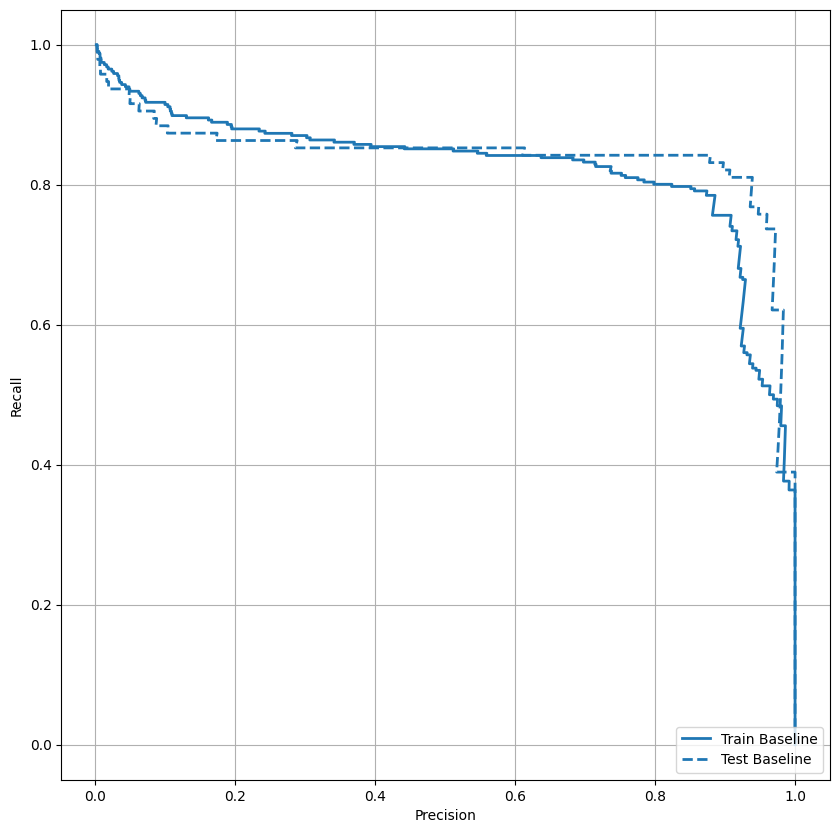

In [65]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

It looks like the precision is relatively high, but the recall and the area under the ROC curve (AUC) aren't as high as you might like. Classifiers often face challenges when trying to maximize both precision and recall, which is especially true when working with imbalanced datasets. It is important to consider the costs of different types of errors in the context of the problem you care about. In this example, a false negative (a fraudulent transaction is missed) may have a financial cost, while a false positive (a transaction is incorrectly flagged as fraudulent) may decrease user happiness.

Class weights
Calculate class weights
The goal is to identify fraudulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class. Note, however, that this does not increase in any way the amount of information of your dataset. In the end, using class weights is more or less equivalent to changing the output bias or to changing the threshold. Let's see how it works out.

In [67]:
neg

np.int64(284315)

In [68]:
pos

np.int64(492)

In [69]:
total

np.int64(284807)

In [66]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


Train a model with class weights
Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using class_weights changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like tf.keras.optimizers.SGD, may fail. The optimizer used here, tf.keras.optimizers.Adam, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [70]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) ####

d:\a27_YEARS_OLD\deep_learning\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - Brier score: 0.0027 - accuracy: 0.9968 - auc: 0.9258 - cross entropy: 0.0151 - fn: 80.8705 - fp: 490.4547 - loss: 0.8653 - prc: 0.4708 - precision: 0.3842 - recall: 0.6698 - tn: 147454.4844 - tp: 168.1232 - val_Brier score: 0.0097 - val_accuracy: 0.9882 - val_auc: 0.9697 - val_cross entropy: 0.0525 - val_fn: 8.0000 - val_fp: 531.0000 - val_loss: 0.0525 - val_prc: 0.5791 - val_precision: 0.1209 - val_recall: 0.9012 - val_tn: 44957.0000 - val_tp: 73.0000
Epoch 2/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - Brier score: 0.0237 - accuracy: 0.9712 - auc: 0.9583 - cross entropy: 0.1048 - fn: 20.9116 - fp: 2688.5225 - loss: 0.2676 - prc: 0.2612 - precision: 0.0486 - recall: 0.8567 - tn: 88386.4609 - tp: 136.0442 - val_Brier score: 0.0202 - val_accuracy: 0.9767 - val_auc: 0.9746 - val_cross entropy: 0.0965 - val_fn: 7.0000 - val_fp: 1054.0000 - val_loss: 0.0965 - val_prc: 0.5383 - val_precision: 0.0656 - val_recall: 0.9136 - val_tn: 

Check training history

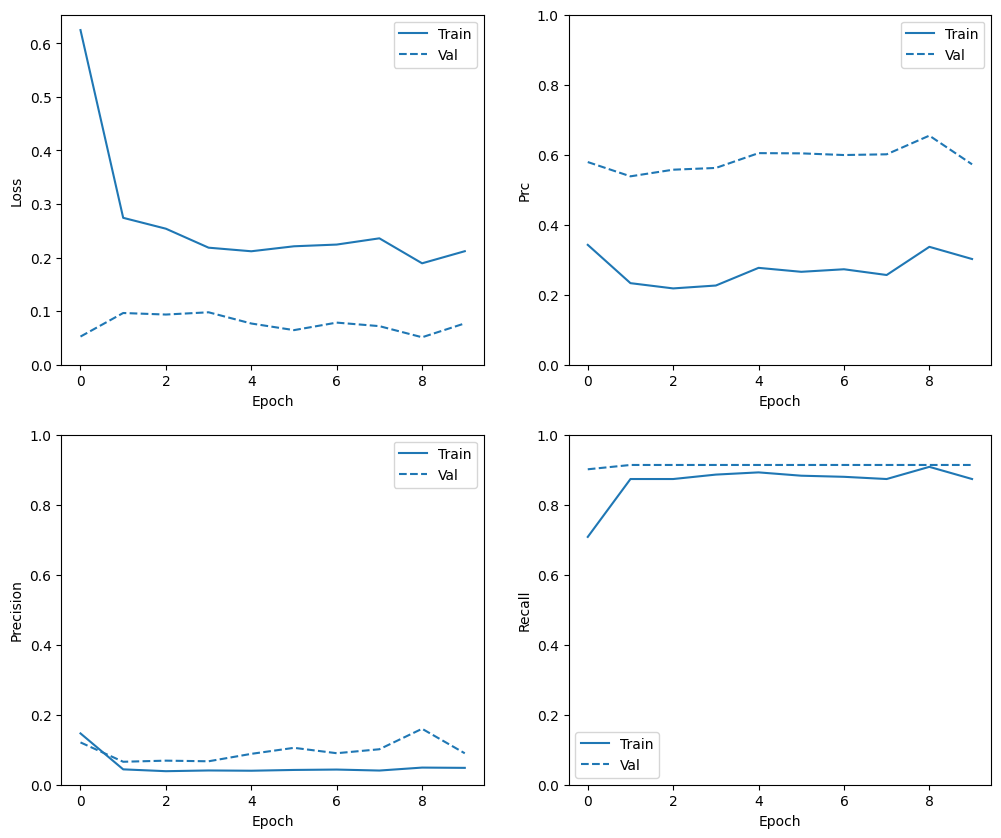

In [71]:
plot_metrics(weighted_history)

Evaluate metrics

In [72]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

2849/2849 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [73]:
train_predictions_weighted[:5]

array([[0.00715168],
       [0.0118601 ],
       [0.00933914],
       [0.00818624],
       [0.26754355]], dtype=float32)

In [74]:
test_predictions_weighted[:5]

array([[0.00808865],
       [0.00848953],
       [0.08319541],
       [0.00392091],
       [0.00853637]], dtype=float32)

In [75]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()



loss :  0.042195528745651245
compile_metrics :  0.042195528745651245



Legitimate Transactions Detected (True Negatives):  56425
Legitimate Transactions Incorrectly Detected (False Positives):  442
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  84
Total Fraudulent Transactions:  95


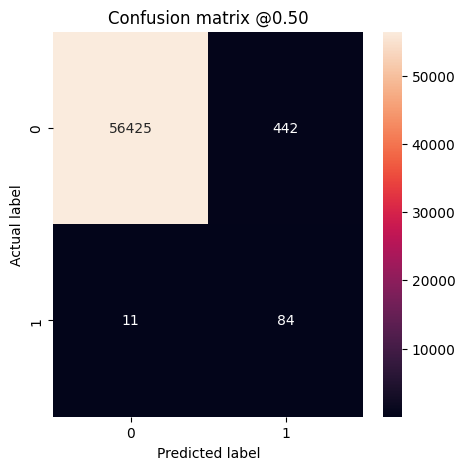

In [76]:
plot_cm(test_labels, test_predictions_weighted)

Here you can see that with class weights the accuracy and precision are lower because there are more false positives, but conversely the recall and AUC are higher because the model also found more true positives. Despite having lower accuracy, this model has higher recall (and identifies more fraudulent transactions than the baseline model at threshold 50%). Of course, there is a cost to both types of error (you wouldn't want to bug users by flagging too many legitimate transactions as fraudulent, either). Carefully consider the trade-offs between these different types of errors for your application.

Compared to the baseline model with changed threshold, the class weighted model is clearly inferior. The superiority of the baseline model is further confirmed by the lower test loss value (cross entropy and mean squared error) and additionally can be seen by plotting the ROC curves of both models together.

Plot the ROC

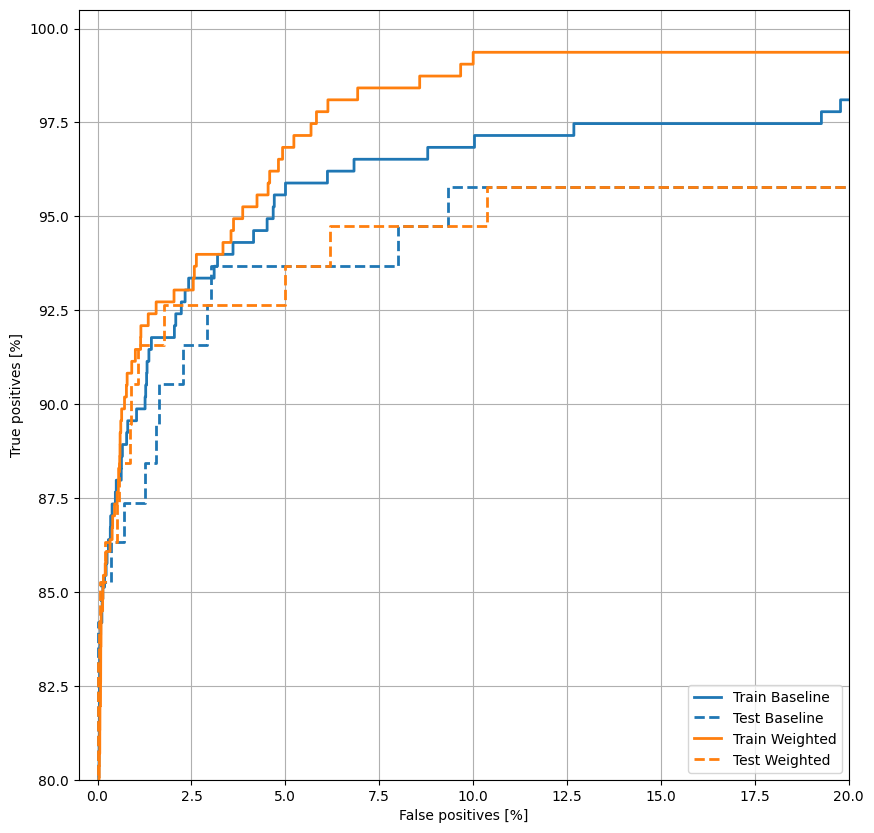

In [77]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

Plot the PRC

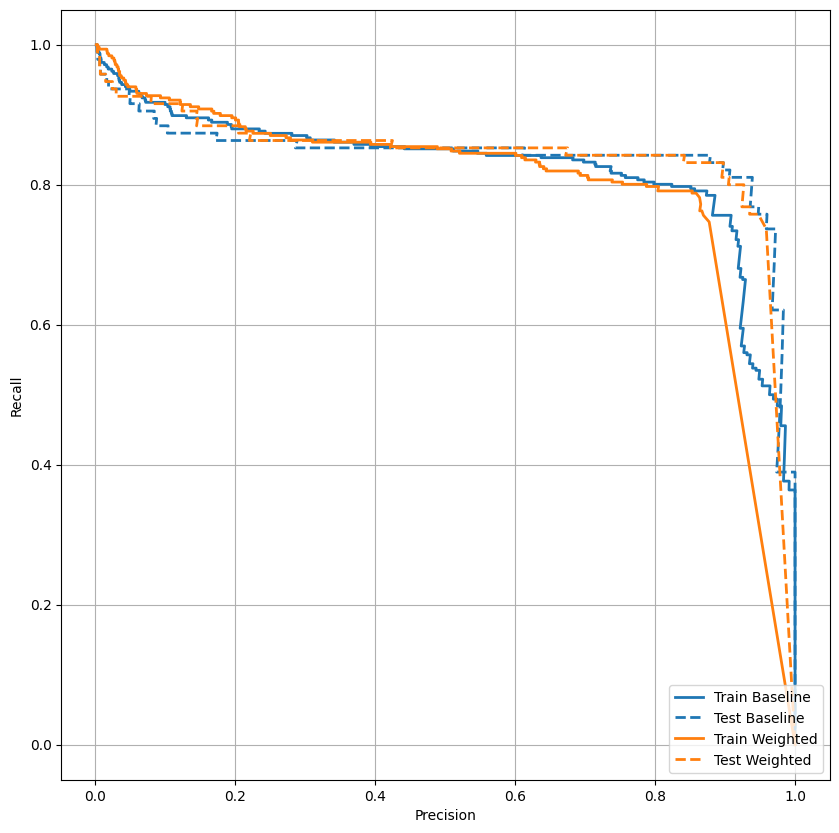

In [78]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right');

##### Oversampling
Oversample the minority class
A related approach would be to resample the dataset by oversampling the minority class.

In [ ]:
pos_features = train_features[bool_train_labels] # 1 fraud
neg_features = train_features[~bool_train_labels] # 0 not fraud 

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [81]:
pos_features[:2]

array([[-0.56083786, -1.01194229, -0.37711206,  3.96689259,  0.55945128,
         0.33105894,  1.59249981, -0.85020091, -0.17670709,  1.6330816 ,
         0.59488366, -2.84945263,  2.38679658,  1.31847303, -0.30928128,
        -0.54873257,  0.94974755, -0.42707474,  0.92544357, -0.04877206,
        -0.56374104, -0.28869308,  0.54682616,  1.79970592, -1.32012763,
         0.15748454,  0.08468615, -2.62040446,  1.72913165],
       [-1.09224443,  0.65124521, -1.83548415,  0.9770453 , -2.94026592,
         0.5618543 ,  1.25582715,  0.16156366, -2.21027885, -3.80959421,
         4.26653625, -2.86754907,  0.46754681, -4.73427241,  0.7642343 ,
        -3.30256119, -5.        , -2.63786871,  1.59380847,  0.87161044,
         0.19681842, -1.22085919,  0.99147463,  0.15891423, -0.36523617,
         1.10445319,  1.0551681 , -0.66133233,  1.84446657]])

In [82]:
pos_labels[:2]

array([[1],
       [1]])

Using NumPy
You can balance the dataset manually by choosing the right number of random indices from the positive example


In [88]:
pos_features.shape

(316, 29)

In [ ]:
len(pos_features) #fraud

316

In [84]:
ids = np.arange(len(pos_features))

In [85]:
ids

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
len(neg_features) # not fraud

181960

In [94]:
choices = np.random.choice(ids, len(neg_features))

In [95]:
choices

array([299, 147, 276, ..., 229, 140, 137])

In [96]:
len(choices)

181960

In [100]:
pos_features[299]

array([-1.48825324, -0.13638374, -3.89260956,  1.55443159, -1.41767837,
        0.47447136, -1.02436603,  1.26141293, -1.72712061, -5.        ,
        4.14347032, -5.        , -0.89556045, -5.        ,  0.59817737,
       -4.90311603, -5.        , -2.11269961, -0.23796636,  2.90745793,
        1.96720435,  1.23221359,  2.19788703, -3.34487345,  0.97680819,
        0.35809466,  1.81258267,  0.7382378 ,  1.79317281])

In [97]:
res_pos_features = pos_features[choices]

In [98]:
res_pos_features.shape

(181960, 29)

In [102]:
pos_labels[299]

array([1])

In [99]:
res_pos_labels = pos_labels[choices]

In [101]:
res_pos_labels.shape

(181960, 1)

In [103]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

In [104]:
len(resampled_labels)

363920

In [105]:
order = np.arange(len(resampled_labels))

In [106]:
order

array([     0,      1,      2, ..., 363917, 363918, 363919])

In [107]:
np.random.shuffle(order)

In [108]:
order

array([ 78094, 281085,  30344, ...,  89312, 135957,  78526])

In [109]:
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

In [110]:
resampled_features.shape

(363920, 29)

Using tf.data
If you're using tf.data the easiest way to produce balanced examples is to start with a positive and a negative dataset, and merge them. See the tf.data guide for more examples.

In [111]:
BUFFER_SIZE = 1000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds



In [116]:
pos_ds = make_ds(pos_features, pos_labels)

In [117]:
pos_ds

<_RepeatDataset element_spec=(TensorSpec(shape=(29,), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

In [ ]:

neg_ds = make_ds(neg_features, neg_labels)

In [119]:
neg_ds

<_RepeatDataset element_spec=(TensorSpec(shape=(29,), dtype=tf.float64, name=None), TensorSpec(shape=(1,), dtype=tf.int64, name=None))>

Merge the two together using tf.data.Dataset.sample_from_datasets:

In [120]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [121]:
resampled_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 29), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [122]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.53125


To use this dataset, you'll need the number of steps per epoch.

The definition of "epoch" in this case is less clear. Say it's the number of batches required to see each negative example once:

In [124]:
neg

np.int64(284315)

In [125]:
BATCH_SIZE

64

In [126]:
2.0*neg/BATCH_SIZE

np.float64(8884.84375)

In [ ]:
# step_per_epoch * batch_size  = total number of dataset

In [ ]:
resampled_steps_per_epoch = int(np.ceil(2.0*neg/BATCH_SIZE))
resampled_steps_per_epoch 

8885

validation data set

In [127]:
val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

Train on the oversampled data
Now try training the model with the resampled data set instead of using class weights to see how these methods compare.

Note: Because the data was balanced by replicating the positive examples, the total dataset size is larger, and each epoch runs for more training steps.

In [128]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

d:\a27_YEARS_OLD\deep_learning\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [129]:

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>

In [130]:
resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=5,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping()],
    validation_data=val_ds)

Epoch 1/5
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - Brier score: 0.0390 - accuracy: 0.9473 - auc: 0.9885 - cross entropy: 0.1317 - fn: 9839.4551 - fp: 7443.9629 - loss: 0.1801 - prc: 0.9782 - precision: 0.9189 - recall: 0.9228 - tn: 191780.6094 - tp: 132281.9688 - val_Brier score: 0.0087 - val_accuracy: 0.9893 - val_auc: 0.9750 - val_cross entropy: 0.0370 - val_fn: 7.0000 - val_fp: 480.0000 - val_loss: 0.0370 - val_prc: 0.6545 - val_precision: 0.1336 - val_recall: 0.9136 - val_tn: 45008.0000 - val_tp: 74.0000
Epoch 2/5
8885/8885 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - Brier score: 0.0221 - accuracy: 0.9703 - auc: 0.9967 - cross entropy: 0.0739 - fn: 5167.8701 - fp: 3138.5037 - loss: 0.0739 - prc: 0.9963 - precision: 0.9775 - recall: 0.9627 - tn: 138999.8125 - tp: 137077.8125 - val_Brier score: 0.0062 - val_accuracy: 0.9921 - val_auc: 0.9608 - val_cross entropy: 0.0291 - val_fn: 7.0000 - val_fp: 353.0000 - val_loss: 0.0291 - val_prc: 0.6427 - val_precision: 0.1733 - val_recall: 0.9136 -

If the training process were considering the whole dataset on each gradient update, this oversampling would be basically identical to the class weighting.

But when training the model batch-wise, as you did here, the oversampled data provides a smoother gradient signal: Instead of each positive example being shown in one batch with a large weight, they're shown in many different batches each time with a small weight.

This smoother gradient signal makes it easier to train the model.

Check training history
Note that the distributions of metrics will be different here, because the training data has a totally different distribution from the validation and test data.

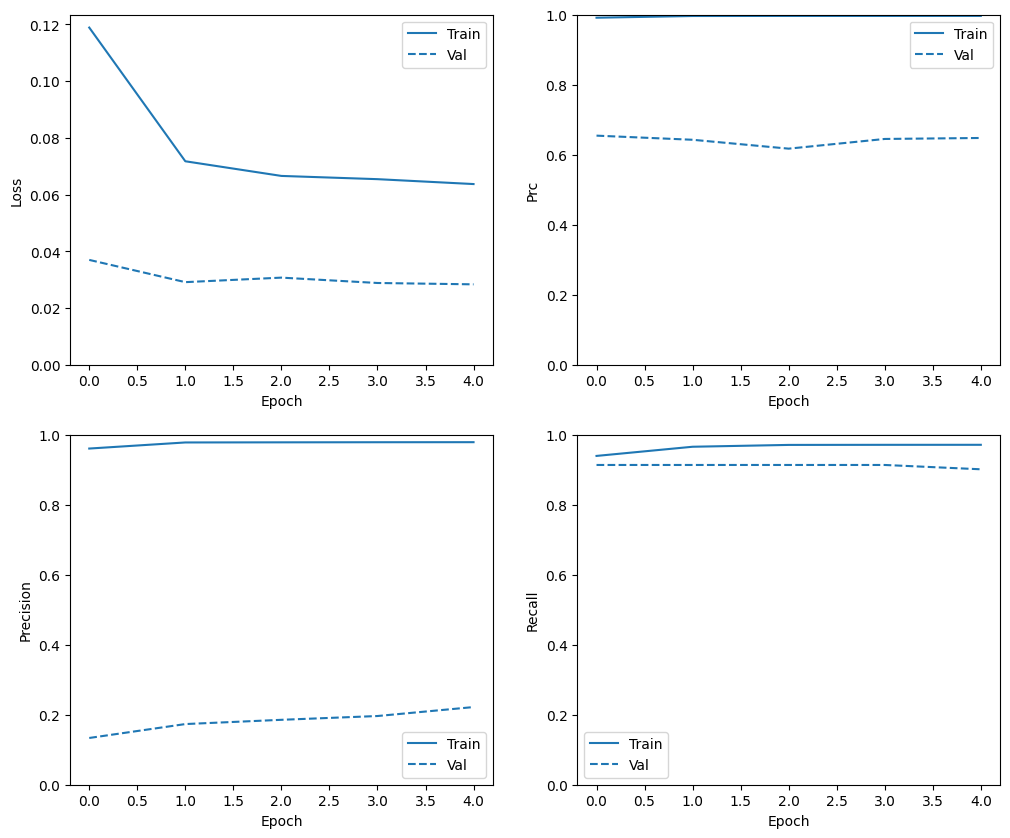

In [131]:
plot_metrics(resampled_history)

Re-train
Because training is easier on the balanced data, the above training procedure may overfit quickly.

So break up the epochs to give the tf.keras.callbacks.EarlyStopping finer control over when to stop training.

In [132]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*5,
    callbacks=[early_stopping()],
    validation_data=(val_ds))

Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - Brier score: 0.0087 - accuracy: 0.9878 - auc: 0.9817 - cross entropy: 0.0399 - fn: 98.5238 - fp: 465.6667 - loss: 0.8038 - prc: 0.6232 - precision: 0.3898 - recall: 0.7741 - tn: 45386.2383 - tp: 319.5238 - val_Brier score: 0.3170 - val_accuracy: 0.4142 - val_auc: 0.9097 - val_cross entropy: 0.8652 - val_fn: 5.0000 - val_fp: 26691.0000 - val_loss: 0.8652 - val_prc: 0.1381 - val_precision: 0.0028 - val_recall: 0.9383 - val_tn: 18797.0000 - val_tp: 76.0000
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - Brier score: 0.2248 - accuracy: 0.6333 - auc: 0.8177 - cross entropy: 0.6537 - fn: 42.5238 - fp: 215.1905 - loss: 0.6537 - prc: 0.8487 - precision: 0.5742 - recall: 0.8812 - tn: 154.4762 - tp: 288.7619 - val_Brier score: 0.2804 - val_accuracy: 0.5025 - val_auc: 0.9325 - val_cross entropy: 0.7790 - val_fn: 4.0000 - val_fp: 22666.0000 - val_loss: 0.7790 - val_prc: 0.2367 - val_precision: 0.0034 - val_recall: 0.9506 - val_tn: 22822.00

Re-check training history

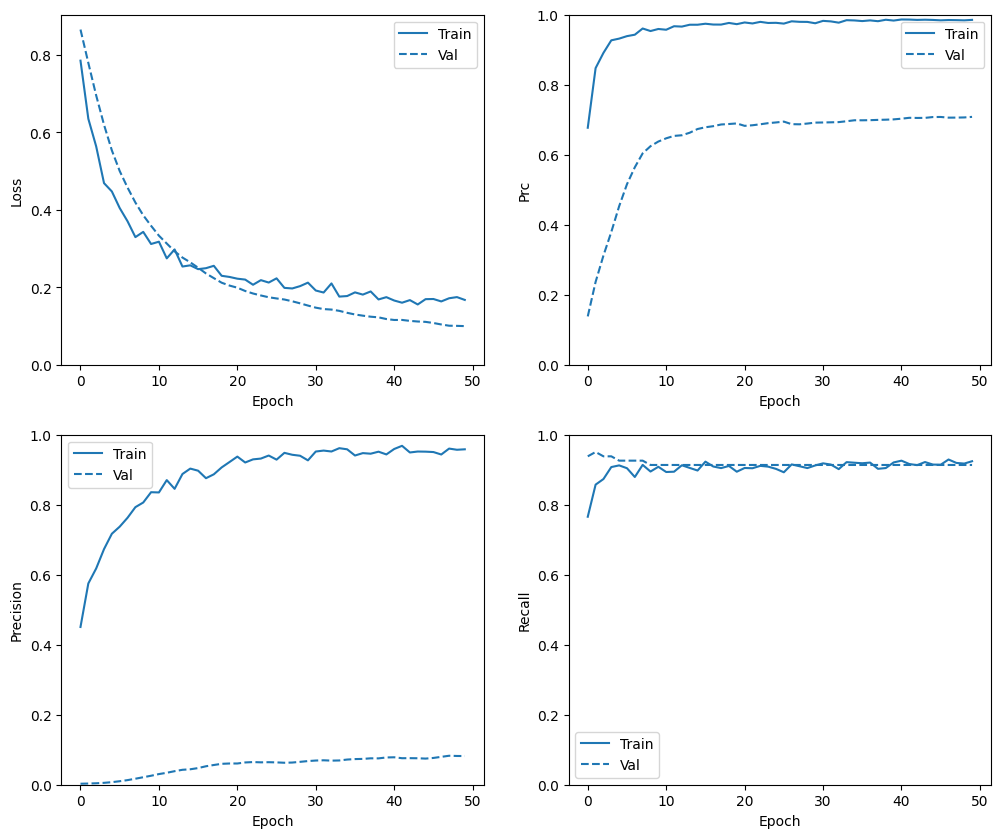

In [133]:
plot_metrics(resampled_history)

Evaluate metrics

In [134]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

2849/2849 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
891/891 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


In [135]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()


loss :  0.09666066616773605
compile_metrics :  0.09666066616773605



Legitimate Transactions Detected (True Negatives):  55857
Legitimate Transactions Incorrectly Detected (False Positives):  1010
Fraudulent Transactions Missed (False Negatives):  11
Fraudulent Transactions Detected (True Positives):  84
Total Fraudulent Transactions:  95


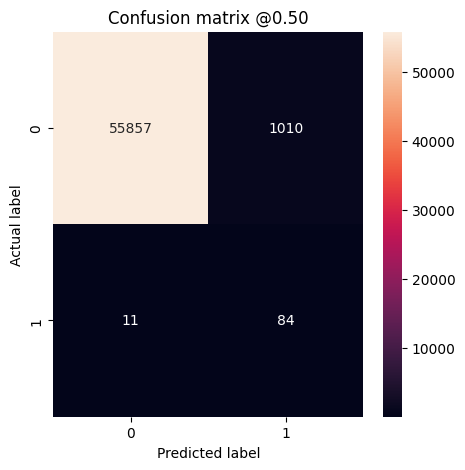

In [136]:
plot_cm(test_labels, test_predictions_resampled)

Plot the ROC

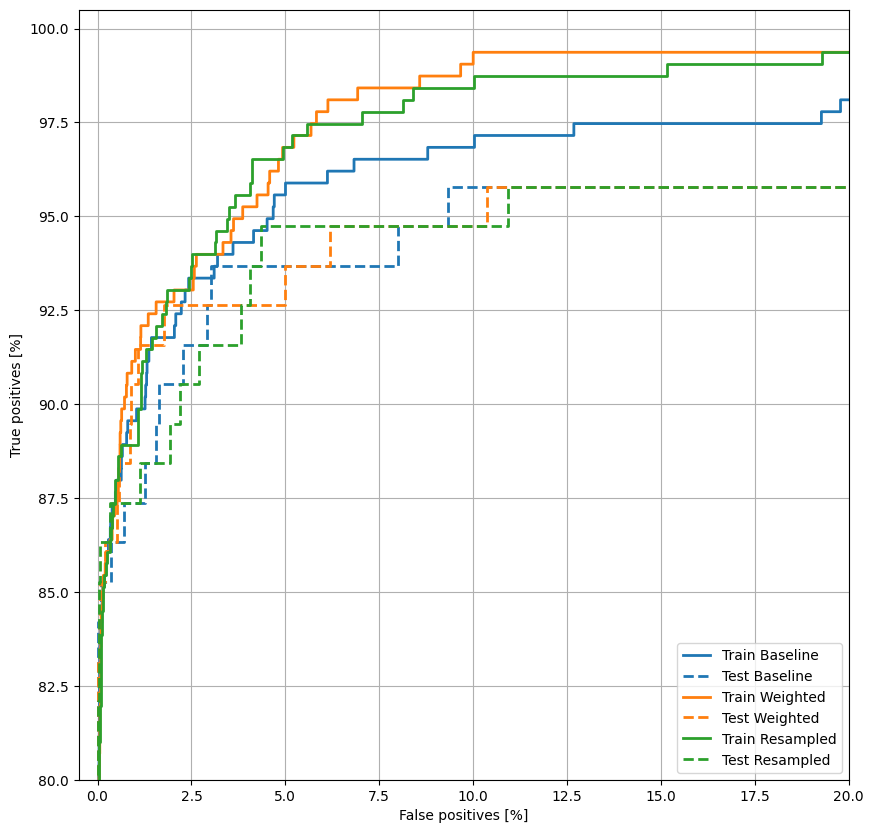

In [137]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')
plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

Plot the AUPRC

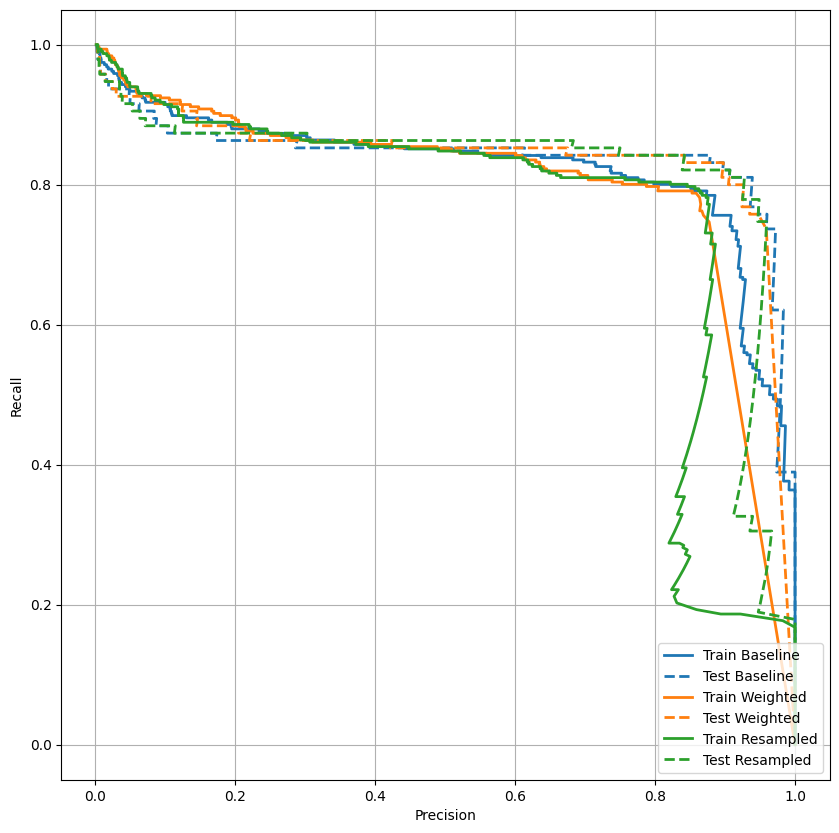

In [138]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');